# Importing original dataset

Skip this section if you already have split up dataset
Link to the original dataset below

In [ ]:
# https://data.world/data-society/employee-compensation-in-sf/workspace/intro

In [ ]:
df = pd.read_csv("drive/My Drive/Data Job/Colab Notebooks/Data Science Nanodegree/Employee_Compensation_SF.csv")
df.head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,Fiscal,2016,1,Public Protection,DAT,District Attorney,311.0,Municipal Attorneys' Association,8100,Legal & Court,8177,Attorney (Civil/Criminal),49919,114473.16,0.0,1500.00,115973.16,21025.98,13068.80,9368.71,43463.49,159436.65
1,Calendar,2013,5,Culture & Recreation,ART,Arts Commission,790.0,"SEIU - Miscellaneous, Local 1021",1800,"Budget, Admn & Stats Analysis",1844,Senior Management Assistant,1225,84077.11,0.0,0.00,84077.11,16587.30,12457.73,6931.91,35976.94,120054.05
2,Calendar,2015,4,Community Health,DPH,Public Health,535.0,"SEIU - Human Services, Local 1021",2900,Human Services,2903,Eligibility Worker,34873,9980.17,0.0,798.43,10778.60,0.00,2254.93,835.11,3090.04,13868.64
3,Fiscal,2015,4,Community Health,DPH,Public Health,250.0,"SEIU - Health Workers, Local 1021",2200,Medical & Dental,2202,Dental Aide,51145,2873.41,0.0,0.00,2873.41,0.00,622.63,222.46,845.09,3718.50
4,Fiscal,2014,5,Culture & Recreation,REC,Recreation and Park Commission,790.0,"SEIU - Miscellaneous, Local 1021",3200,Recreation,3279,Recreation Leader,48705,6701.85,0.0,176.70,6878.55,0.00,2711.66,538.43,3250.09,10128.64


The original dataset was too large to be uploaded on Github. The following code splits the dataframe into manageable csv files that could be uploaded to Github

In [ ]:
df.reset_index(inplace=True) #in order to later concatenate the dataframe back together we set the original index as column

In [ ]:
df.head(2)

,index,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,0,Fiscal,2016,1,Public Protection,DAT,District Attorney,311.0,Municipal Attorneys' Association,8100,Legal & Court,8177,Attorney (Civil/Criminal),49919,114473.16,0.0,1500.0,115973.16,21025.98,13068.80,9368.71,43463.49,159436.65
1,1,Calendar,2013,5,Culture & Recreation,ART,Arts Commission,790.0,"SEIU - Miscellaneous, Local 1021",1800,"Budget, Admn & Stats Analysis",1844,Senior Management Assistant,1225,84077.11,0.0,0.0,84077.11,16587.30,12457.73,6931.91,35976.94,120054.05


In [ ]:
part_list = list(range(round(df.shape[0]/100000)))
for part in part_list:
  if part != part_list[-1]:
    df_part = df[part * round((df.shape[0])/len(part_list)) : (part + 1) * round((df.shape[0])/len(part_list))]
    df_part.to_csv(r'drive/My Drive/Data Job/Colab Notebooks/Data Science Nanodegree/Employee_Compensation_SF_{}.csv'.format(part))
  else:
    df_part = df[part * round((df.shape[0])/len(part_list)) : ]
    df_part.to_csv(r'drive/My Drive/Data Job/Colab Notebooks/Data Science Nanodegree/Employee_Compensation_SF_{}.csv'.format(part))

#Business Questions

The questions we would like to answer:

1.  What is the most profitable profession in the city system?
2.  Do people who earn more get higher percentage of their compensation in benefits than lower income?
3.  Do people who work overtime tend to earn more or less than average?
4.  What are the professions / Job titles who earn average amount of money?
5.  What percentage of city employees receive benefits through work? If some do not, what are job titles?




#Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

from google.colab import files
from sklearn.model_selection import train_test_split

import statistics

#Importing Dataset

In [2]:
parts = 3 #number of dataframe parts 
part_list = list(range(parts))

In [3]:
data = []
for part in part_list:
  data.append(pd.read_csv("drive/My Drive/Data Job/Colab Notebooks/Data Science Nanodegree/Employee_Compensation_SF_{}.csv".format(part)))

df_comb = pd.concat(data, ignore_index=True)


In [4]:
df_comb.drop(['Unnamed: 0'], axis = 1,inplace= True)
df_comb.columns

Index(['Year Type', 'Year', 'Organization Group Code', 'Organization Group',
       'Department Code', 'Department', 'Union Code', 'Union',
       'Job Family Code', 'Job Family', 'Job Code', 'Job',
       'Employee Identifier', 'Salaries', 'Overtime', 'Other Salaries',
       'Total Salary', 'Retirement', 'Health/Dental', 'Other Benefits',
       'Total Benefits', 'Total Compensation'],
      dtype='object')

In [5]:
df_comb.head(2)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,Fiscal,2016,1,Public Protection,DAT,District Attorney,311.0,Municipal Attorneys' Association,8100,Legal & Court,8177,Attorney (Civil/Criminal),49919,114473.16,0.0,1500.0,115973.16,21025.98,13068.80,9368.71,43463.49,159436.65
1,Calendar,2013,5,Culture & Recreation,ART,Arts Commission,790.0,"SEIU - Miscellaneous, Local 1021",1800,"Budget, Admn & Stats Analysis",1844,Senior Management Assistant,1225,84077.11,0.0,0.0,84077.11,16587.30,12457.73,6931.91,35976.94,120054.05


in the histogram below we could the salary dsitribution is skewed to the right and peaks at about $100k per year

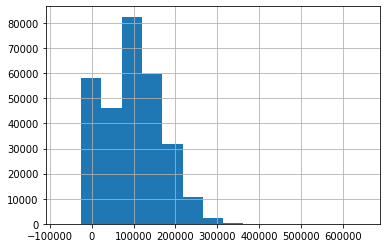

In [6]:
df_comb['Total Compensation'].hist(bins = 15)

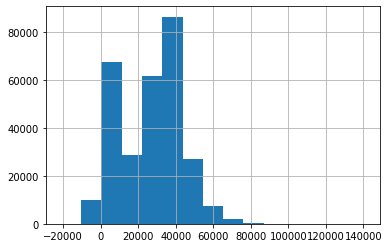

In [7]:
df_comb['Total Benefits'].hist(bins = 15)

Wait a minute! Are these negative salaries/benefits? Does not seem right. Let's look into it

In [8]:
df_comb[(df_comb['Total Compensation']<=0) | (df_comb['Total Salary']<0) | (df_comb['Salaries']<0) | (df_comb['Other Salaries']<0) | (df_comb['Retirement']<0) | (df_comb['Health/Dental']<0) | (df_comb['Other Benefits']<0) | (df_comb['Total Benefits']<0)].sort_values('Total Compensation').head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
203975,Fiscal,2014,1,Public Protection,FIR,Fire Department,323.0,Members of Boards and Commissions,0900,Management,0114,"Bdcomm Mbr, Grp5,M$100/Mo",12878,-68771.78,0.0,0.00,-68771.78,0.00,17.98,-5328.81,-5310.83,-74082.61
140656,Fiscal,2013,3,Human Welfare & Neighborhood Development,HRC,Human Rights Commission,790.0,"SEIU - Miscellaneous, Local 1021",2900,Human Services,2996,"Rep, Human Rights Comm",33028,-17635.32,0.0,782.28,-16853.04,-3190.24,-2940.47,-1378.51,-7509.22,-24362.26
69411,Fiscal,2015,4,Community Health,DPH,Public Health,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",2100,Hospital Administration,2119,Health Care Analyst,35658,-7423.00,0.0,0.00,-7423.00,-1582.59,-1245.26,-595.47,-3423.32,-10846.32
220161,Calendar,2014,4,Community Health,DPH,Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2328,Nurse Practitioner,3768,12329.19,0.0,0.00,12329.19,-30469.00,0.00,9173.85,-21295.15,-8965.96
212789,Fiscal,2016,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,856.0,"Teamsters - Miscellaneous, Local 856",7400,Skilled Labor,7444,Parking Meter Repairer,19982,-4770.20,0.0,0.00,-4770.20,-1069.96,-847.97,-241.98,-2159.91,-6930.11
92189,Fiscal,2014,4,Community Health,DPH,Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,30584,-5255.50,0.0,69.89,-5185.61,-1212.70,0.00,-25.49,-1238.19,-6423.80
43356,Fiscal,2013,4,Community Health,DPH,Public Health,790.0,"SEIU - Miscellaneous, Local 1021",9900,Public Service Aide,9924,PS Aide Health Services,35253,-3772.90,0.0,0.00,-3772.90,0.00,-1427.89,-293.95,-1721.84,-5494.74
243714,Fiscal,2014,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",2900,Human Services,2978,Contract Compliance Officer 2,10043,0.00,0.0,0.00,0.00,-4657.96,0.00,0.00,-4657.96,-4657.96
285516,Fiscal,2014,6,General Administration & Finance,BOS,Board of Supervisors,22.0,"Prof & Tech Engineers - Personnel, Local 21",1800,"Budget, Admn & Stats Analysis",1835,Legislative Assistant,771,-2997.00,0.0,0.00,-2997.00,0.00,-479.41,-232.03,-711.44,-3708.44
212810,Fiscal,2014,6,General Administration & Finance,ADM,General Services Agency - City Admin,790.0,"SEIU - Miscellaneous, Local 1021",2700,Housekeeping & Laundry,2708,Custodian,33418,-3345.90,0.0,-33.44,-3379.34,0.00,0.00,-266.97,-266.97,-3646.31


There is a thing like a negative salary, if for example the employee took a loan from the company and is repaying it with salary deduction. This could overcomplicate our model. For the sake of time constrain for this project, we would drop all rows that have negative salary, negative total compensation. We would keep negative health/dental as some employees may contribute to their insurance resulting in negative benefit

In [9]:
df_comb = df_comb[(df_comb['Total Compensation']>0) & (df_comb['Total Salary']>0)]
df_comb = df_comb[(df_comb['Salaries']>=0) | (df_comb['Other Salaries']>=0) | (df_comb['Retirement']>=0) | (df_comb['Total Benefits']>=0)]

df_comb.sort_values('Total Compensation').head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
202891,Fiscal,2014,6,General Administration & Finance,ADM,General Services Agency - City Admin,790.0,"SEIU - Miscellaneous, Local 1021",1800,"Budget, Admn & Stats Analysis",1840,Junior Management Assistant,3095,0.57,0.0,0.00,0.57,0.13,0.12,0.05,0.30,0.87
175430,Calendar,2014,6,General Administration & Finance,ADM,General Services Agency - City Admin,790.0,"SEIU - Miscellaneous, Local 1021",1800,"Budget, Admn & Stats Analysis",1840,Junior Management Assistant,3095,0.57,0.0,0.00,0.57,0.13,0.12,0.05,0.30,0.87
33280,Fiscal,2013,6,General Administration & Finance,HSS,Health Service System,351.0,Municipal Executive Association - Miscellaneous,9100,Street Transit,9187,"Deputy Dir II, MTA",36609,0.00,0.0,1.54,1.54,0.00,0.00,0.00,0.00,1.54
104617,Fiscal,2015,3,Human Welfare & Neighborhood Development,CSS,Child Support Services,790.0,"SEIU - Miscellaneous, Local 1021",8100,Legal & Court,8158,Child Support Officer II,41318,0.00,0.0,1.83,1.83,0.00,0.00,0.14,0.14,1.97
24175,Fiscal,2016,4,Community Health,DPH,Public Health,250.0,"SEIU - Health Workers, Local 1021",2600,Dietary & Food,2654,Cook,33365,0.00,0.0,2.21,2.21,0.00,0.00,0.17,0.17,2.38


Annual salaries near 1 dollar still seem strange to me. Let's look at box plot for possible outliers

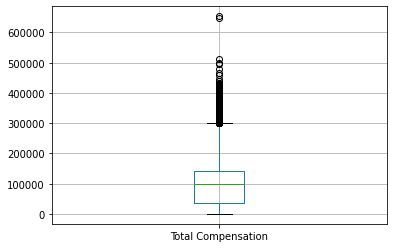

In [10]:
df_comb[['Total Compensation']].boxplot()

The plot does not show any low outliers. It seems these near dollar salaries is something normal?

#Question 1

What is the most profitable profession in the city system?

Let's figure out who are the top earners and what their salary information is

In [11]:
df_comb[df_comb['Total Compensation'] > df_comb.quantile(0.99)[-1]][['Job', 'Total Compensation']]

,Job,Total Compensation
133,Senior Physician Specialist,297001.71
218,Senior Physician Specialist,305700.60
372,"Battlion Chief, Fire Suppressi",302932.50
430,Dep Dir IV,321615.86
458,Nursing Supervisor Psychiatric,302958.02
...,...,...
291565,Supervising Physician Spec,293285.65
291666,Dept Head V,353667.55
291759,Firefighter,268339.50
291788,Anesthetist,359840.09


The following jobs are the highest earners among SF city employees 

In [12]:
df_comb[df_comb['Total Compensation'] > df_comb.quantile(0.99)[-1]]['Job'].unique()

array(['Senior Physician Specialist', 'Battlion Chief, Fire Suppressi',
       'Dep Dir IV', 'Nursing Supervisor Psychiatric', 'Police Officer 3',
       'Lieutenant, Fire Suppression', 'Engineer',
       'Captain, Emergency Med Svcs', 'Lieutenant 3',
       'Assistant Deputy Chief 2', 'Captain, Fire Suppression',
       'Assistant Chief Attorney 1', 'Captain 3',
       'Head Atty, Civil & Criminal', 'Dept Head III', 'Manager VII',
       'Dep Dir V', 'Manager VIII', 'Lieutenant 2', 'Commander 3',
       'Sergeant 3', 'Asst Chf Of Dept (Fire Dept)', 'Dept Head IV',
       'Inspector 3', 'EMT/Paramedic/Firefighter', 'Deputy Chief 3',
       'Nurse Manager', 'Capt,Fire Prev Or Fire Invsgtn',
       "Sheriff's Sergeant", 'Executive Contract Employee',
       'Chief Deputy Sheriff', 'Nursing Supervisor', 'Nurse Practitioner',
       'Anesthetist', 'Supervising Physician Spec', 'Firefighter',
       'Dep Dir III', 'Deputy Sheriff', 'Sheriff (SFERS)', 'Manager VI',
       'Dir Emp Relations 

Their total compensation

In [13]:
top_1_per = df_comb[df_comb['Total Compensation'] > df_comb.quantile(0.99)[-1]][['Job', 'Total Compensation', 'Department', 'Total Salary', 'Total Benefits']].sort_values(by = 'Total Compensation', ascending = False)
top_1_per

,Job,Total Compensation,Department,Total Salary,Total Benefits
219830,Chief Investment Officer,653498.15,Retirement System,515101.80,138396.35
36326,Chief Investment Officer,648875.24,Retirement System,507831.60,141043.64
267960,Deputy Chief 3,510574.44,Police,471952.64,38621.80
219896,Asst Med Examiner,497505.00,General Services Agency - City Admin,409892.62,87612.38
116381,Chief Investment Officer,495720.60,Retirement System,379201.70,116518.90
...,...,...,...,...,...
241882,"Head Atty, Civil & Criminal",266195.90,Public Defender,201935.52,64260.38
242100,Assistant Chief Attorney 2,266192.17,District Attorney,205687.51,60504.66
153362,Captain 3,266188.83,Police,207715.36,58473.47
5187,Sheriff's Sergeant,266157.46,Sheriff,212960.54,53196.92


What is the range of their salaries, benefits, and total compensation? 

In [14]:
print('Total Compensations range from {} to {} for the top 1% of employees'.format(top_1_per['Total Compensation'].min(), top_1_per['Total Compensation'].max()))
print('Total Salaries range from {} to {} for the top 1% of employees'.format(top_1_per['Total Salary'].min(), top_1_per['Total Salary'].max()))
print('Total Benefits range from {} to {} for the top 1% of employees'.format(top_1_per['Total Benefits'].min(), top_1_per['Total Benefits'].max()))


Total Compensations range from 266127.73 to 653498.15 for the top 1% of employees
Total Salaries range from 190333.34 to 515101.8 for the top 1% of employees
Total Benefits range from 0.0 to 141043.64 for the top 1% of employees


So what departments account for the most highest earners?

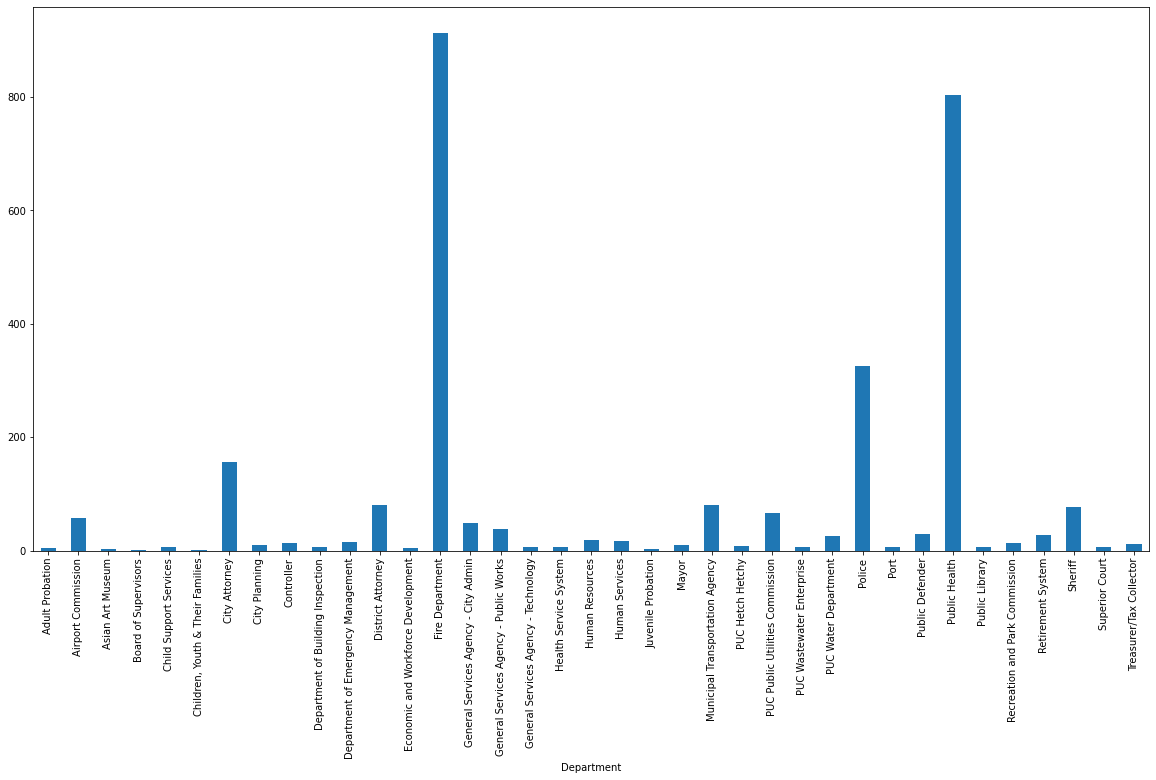

In [15]:
top_1_per.groupby('Department')['Job'].count().plot(kind = 'bar', figsize=(20,10))

That's on top 1%. Let's look at the top 10 employees

In [16]:

top_10 = df_comb.sort_values('Total Compensation', ascending= False).head(10).reset_index()
top_10[['Job', 'Department', 'Total Compensation', 'Total Salary', 'Total Benefits']]

,Job,Department,Total Compensation,Total Salary,Total Benefits
0,Chief Investment Officer,Retirement System,653498.15,515101.80,138396.35
1,Chief Investment Officer,Retirement System,648875.24,507831.60,141043.64
2,Deputy Chief 3,Police,510574.44,471952.64,38621.80
3,Asst Med Examiner,General Services Agency - City Admin,497505.00,409892.62,87612.38
4,Chief Investment Officer,Retirement System,495720.60,379201.70,116518.90
5,Asst Med Examiner,General Services Agency - City Admin,480509.28,397574.04,82935.24
6,Chief Of Police,Police,466798.21,392721.50,74076.71
7,Asst Med Examiner,General Services Agency - City Admin,460271.32,373217.00,87054.32
8,Chief Investment Officer,Retirement System,445102.40,339653.70,105448.70
9,Deputy Chief 3,Police,438158.70,366487.20,71671.50


In [17]:
print('Total Compensations range from {} to {} for the top 10 of employees'.format(top_10['Total Compensation'].min(), top_10['Total Compensation'].max()))
print('Total Salaries range from {} to {} for the top 10 of employees'.format(top_10['Total Salary'].min(), top_10['Total Salary'].max()))
print('Total Benefits range from {} to {} for the top 10 of employees'.format(top_10['Total Benefits'].min(), top_10['Total Benefits'].max()))

Total Compensations range from 438158.7 to 653498.15 for the top 10 of employees
Total Salaries range from 339653.7 to 515101.8 for the top 10 of employees
Total Benefits range from 38621.8 to 141043.64 for the top 10 of employees


Which departments are employing our top 10?

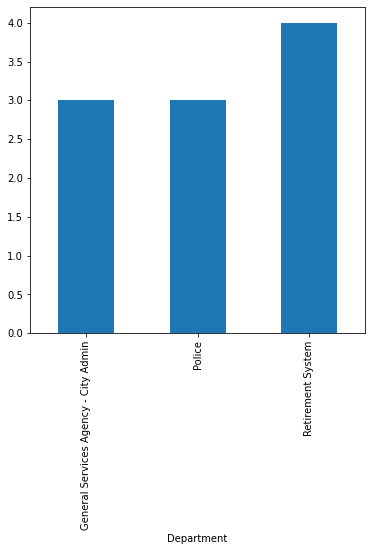

In [18]:
top_10.groupby('Department')['Job'].count().plot(kind = 'bar', figsize=(6,6))


General Services Agency - City Admin, Police, and Retirement System employ top 10 highest earners in the city system

#Question 2

Do people who earn more get higher percentage of their compensation in benefits than lower income?

Let's focus on these three columns

In [19]:
df_comb[['Job', 'Total Salary', 'Total Benefits', 'Total Compensation']]

,Job,Total Salary,Total Benefits,Total Compensation
0,Attorney (Civil/Criminal),115973.16,43463.49,159436.65
1,Senior Management Assistant,84077.11,35976.94,120054.05
2,Eligibility Worker,10778.60,3090.04,13868.64
3,Dental Aide,2873.41,845.09,3718.50
4,Recreation Leader,6878.55,3250.09,10128.64
...,...,...,...,...
291820,Child Support Officer III,93905.01,39521.94,133426.95
291821,Medical Evaluations Assistant,64101.91,32013.46,96115.37
291822,Special Nurse,14165.38,2319.96,16485.34
291823,Psychiatric Social Worker,78865.86,34995.50,113861.36


In [20]:
df_comb['Benefit Portion'] = df_comb['Total Benefits']/df_comb['Total Compensation']

In [21]:
df_comb[['Job', 'Total Salary', 'Total Benefits', 'Total Compensation', 'Benefit Portion']]

,Job,Total Salary,Total Benefits,Total Compensation,Benefit Portion
0,Attorney (Civil/Criminal),115973.16,43463.49,159436.65,0.272607
1,Senior Management Assistant,84077.11,35976.94,120054.05,0.299673
2,Eligibility Worker,10778.60,3090.04,13868.64,0.222808
3,Dental Aide,2873.41,845.09,3718.50,0.227266
4,Recreation Leader,6878.55,3250.09,10128.64,0.320881
...,...,...,...,...,...
291820,Child Support Officer III,93905.01,39521.94,133426.95,0.296207
291821,Medical Evaluations Assistant,64101.91,32013.46,96115.37,0.333073
291822,Special Nurse,14165.38,2319.96,16485.34,0.140729
291823,Psychiatric Social Worker,78865.86,34995.50,113861.36,0.307352


For the sake of this question, we would drop everyone whose benefit portion is less then zero

In [22]:
df_q2 = df_comb[df_comb['Benefit Portion'] >= 0]

What is the mean benefit portion across the city?

In [23]:
df_q2['Benefit Portion'].mean()

0.2797732424525513

In [24]:
print('Benefit portions range from {} to {} for all employees'
.format(df_q2['Benefit Portion'].min(), df_q2['Benefit Portion'].max()))



Benefit portions range from 0.0 to 0.9798488664987406 for all employees


How about benefits for the top 1%

In [25]:
top_1_per_ben = df_q2[df_q2['Total Compensation'] > df_q2.quantile(0.99)[-2]][['Job', 'Total Salary', 'Total Benefits', 'Total Compensation', 'Benefit Portion']]
top_1_per_ben

,Job,Total Salary,Total Benefits,Total Compensation,Benefit Portion
133,Senior Physician Specialist,223357.02,73644.69,297001.71,0.247960
218,Senior Physician Specialist,234432.76,71267.84,305700.60,0.233130
372,"Battlion Chief, Fire Suppressi",245676.76,57255.74,302932.50,0.189005
430,Dep Dir IV,240727.00,80888.86,321615.86,0.251508
458,Nursing Supervisor Psychiatric,236573.12,66384.90,302958.02,0.219122
...,...,...,...,...,...
291565,Supervising Physician Spec,225896.50,67389.15,293285.65,0.229773
291666,Dept Head V,267936.60,85730.95,353667.55,0.242405
291759,Firefighter,223145.78,45193.72,268339.50,0.168420
291788,Anesthetist,279965.08,79875.01,359840.09,0.221974


In [26]:
top_1_per_ben['Benefit Portion'].mean()

0.21044150693057784

Let's compare this percentage to the bottom 25% of employees

In [27]:
bot_25_per_ben = df_q2[df_q2['Total Compensation'] < df_q2.quantile(0.25)[-2]][['Job', 'Total Salary', 'Total Benefits', 'Total Compensation', 'Benefit Portion']]
bot_25_per_ben

,Job,Total Salary,Total Benefits,Total Compensation,Benefit Portion
2,Eligibility Worker,10778.60,3090.04,13868.64,0.222808
3,Dental Aide,2873.41,845.09,3718.50,0.227266
4,Recreation Leader,6878.55,3250.09,10128.64,0.320881
10,Publ Svc Aide-Asst To Prof,7091.33,2910.83,10002.16,0.291020
23,Special Nurse,852.23,3081.98,3934.21,0.783380
...,...,...,...,...,...
291807,Publ Svc Aide-Asst To Prof,6418.08,2523.32,8941.40,0.282206
291811,Recreation Leader,17889.15,8089.54,25978.69,0.311391
291817,Recreation Leader,760.96,352.10,1113.06,0.316335
291822,Special Nurse,14165.38,2319.96,16485.34,0.140729


In [28]:
bot_25_per_ben['Benefit Portion'].mean()

0.2746776562666851

(0.0, 1.0)

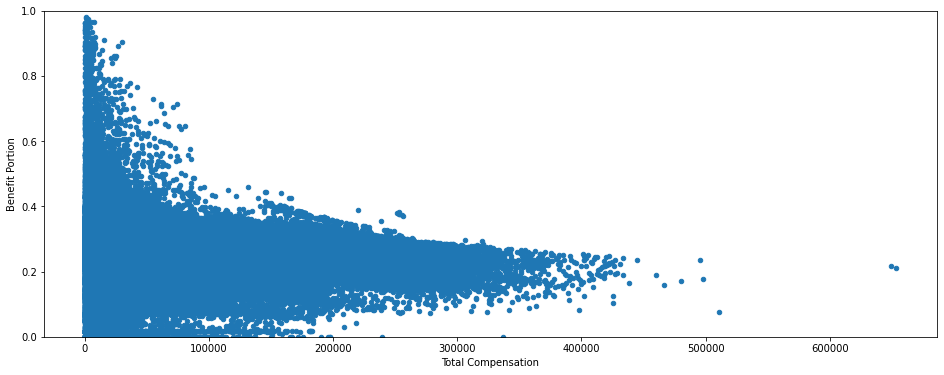

In [29]:
df_q2.plot.scatter(x = 'Total Compensation', y = 'Benefit Portion', figsize=(16,6))
plt.ylim(0, 1)


In [30]:
mean_sal = []
for bin in list(range(0, 100, 10)):
  tmp = df_q2[(df_q2['Total Compensation'] > df_q2.quantile(bin/100)[-2]) & (df_q2['Total Compensation'] < df_q2.quantile((bin+10)/100)[-2])]['Benefit Portion']
  mean_sal.append(tmp.mean())

In [31]:
percentiles = pd.DataFrame(data=[list(range(0, 100, 10)), mean_sal]).transpose()
percentiles.columns = ['Percentile', 'Benefit Portion']
percentiles

,Percentile,Benefit Portion
0,0.0,0.266955
1,10.0,0.278041
2,20.0,0.286093
3,30.0,0.304642
4,40.0,0.315846
5,50.0,0.303651
6,60.0,0.290746
7,70.0,0.272958
8,80.0,0.252156
9,90.0,0.226653


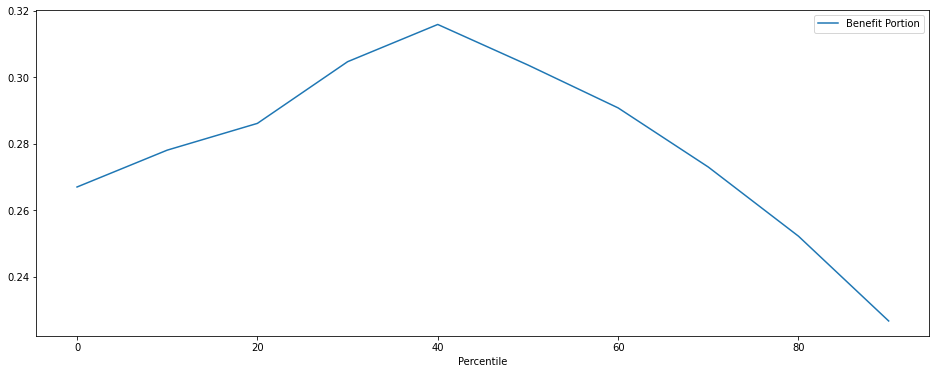

In [32]:
percentiles.plot(x = 'Percentile', y = 'Benefit Portion', figsize=(16,6))


It appears that at the bottom percentiles people tend to receive very little benefits, that are small even compared to a small salary. At 50-ish percentiles, people tend to receive a standard package of benefits, which could make up a large portion of one's total compensation since the salary is still not very significant. While the highest percentiles receive so much compensation that even better-than-standard benefits package is much smaller than the paycheck.

#Question 3

Do people who work overtime tend to earn more or less than average?

Let's take a look at overtime column

In [33]:
df_comb[['Job', 'Total Compensation', 'Overtime']]

,Job,Total Compensation,Overtime
0,Attorney (Civil/Criminal),159436.65,0.00
1,Senior Management Assistant,120054.05,0.00
2,Eligibility Worker,13868.64,0.00
3,Dental Aide,3718.50,0.00
4,Recreation Leader,10128.64,0.00
...,...,...,...
291820,Child Support Officer III,133426.95,0.00
291821,Medical Evaluations Assistant,96115.37,0.00
291822,Special Nurse,16485.34,0.00
291823,Psychiatric Social Worker,113861.36,0.00


First of all what is the average amount for overtime and compensation?

In [34]:
df_comb[['Total Compensation', 'Overtime']].mean()

Total Compensation    98050.401754
Overtime               4413.530452
dtype: float64

It appears people on average people do work overtime. How if that is overtime for the entire year, how much is it for the month? 

In [35]:
df_comb[['Total Compensation', 'Overtime']].mean()/12


Total Compensation    8170.866813
Overtime               367.794204
dtype: float64

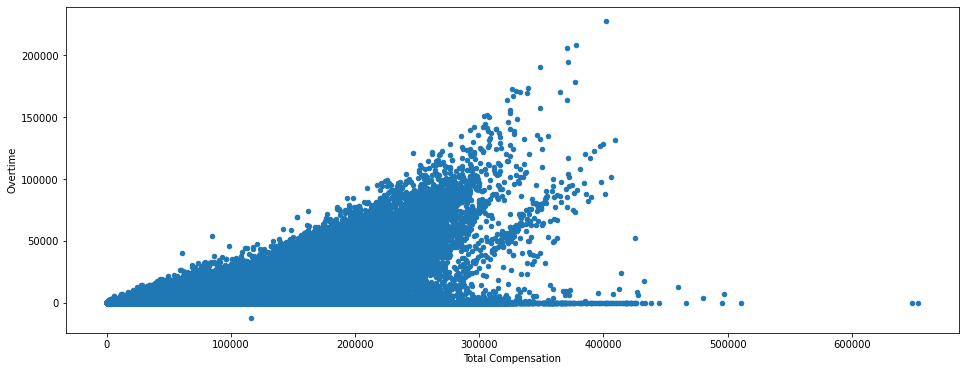

In [36]:
df_comb.plot.scatter(x = 'Total Compensation', y = 'Overtime', figsize=(16,6))

All the data points are concentrated in the lower right side. People in general do not over work overtime, but the amount of overtime does increase as salary increases. We have a couple of outliers that clearly earn more than anyone and do not work over time at all.

In [37]:
mean_sal = []
for bin in list(range(0, 100, 10)):
  tmp = df_comb[(df_comb['Total Compensation'] > df_comb.quantile(bin/100)[-2]) & (df_comb['Total Compensation'] < df_comb.quantile((bin+10)/100)[-2])]['Overtime']
  mean_sal.append(tmp.mean())

In [38]:
percentiles = pd.DataFrame(data=[list(range(0, 100, 10)), mean_sal]).transpose()
percentiles.columns = ['Percentile', 'Overtime']
percentiles

,Percentile,Overtime
0,0.0,47.261942
1,10.0,149.024942
2,20.0,617.802935
3,30.0,1378.649492
4,40.0,1490.899698
5,50.0,2804.570598
6,60.0,5020.039072
7,70.0,6444.996160
8,80.0,7852.791442
9,90.0,18329.784816


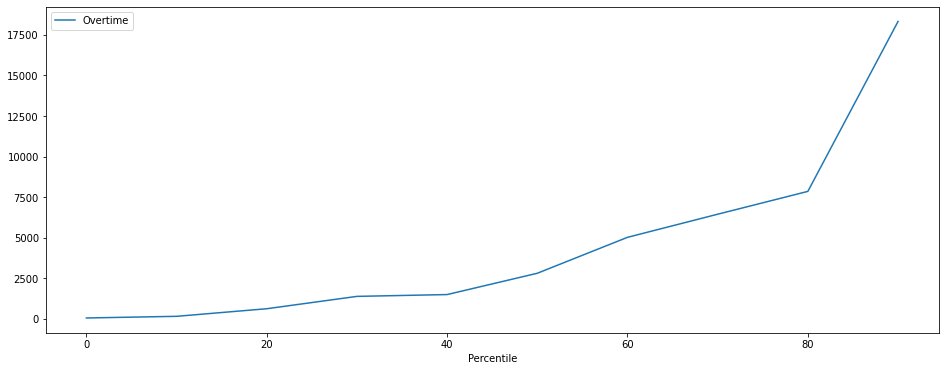

In [39]:
percentiles.plot(x = 'Percentile', y = 'Overtime', figsize=(16,6))


#Question 4

What are the professions / Job titles who earn average amount of money?

Average amount in compensation we would consider 5% of people who earn around 50 percentile

In [40]:
df_comb.quantile([0.475, 0.525])

,Year,Organization Group Code,Union Code,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation,Benefit Portion
0.475,2014.0,2.0,535.0,25617.0,60168.220,0.0,624.000,64882.000,12688.928,11537.074,4027.348,29571.234,94279.850,0.288626
0.525,2014.0,3.0,790.0,28347.0,64633.444,0.0,897.788,71038.912,13738.288,12310.302,4628.056,31146.152,102262.294,0.294325


In [41]:
ave_50_sal = df_comb[(df_comb['Total Compensation'] < df_comb.quantile(0.525)[-2]) & (df_comb['Total Compensation'] > df_comb.quantile(0.475)[-2])][['Job','Department', 'Total Salary', 'Total Benefits', 'Total Compensation', 'Benefit Portion']]
ave_50_sal

,Job,Department,Total Salary,Total Benefits,Total Compensation,Benefit Portion
24,Patient Care Assistant,Public Health,66750.79,30318.11,97068.90,0.312336
74,Police Officer 3,Police,80419.55,17431.15,97850.70,0.178140
82,Gardener,Recreation and Park Commission,63199.20,31909.79,95108.99,0.335508
83,Assistant Storekeeper,Public Health,68562.18,28571.48,97133.66,0.294146
135,Transit Operator,Municipal Transportation Agency,64868.56,34432.22,99300.78,0.346747
...,...,...,...,...,...,...
291755,Comm Pol Svcs Aide Supervisor,Police,66348.37,28899.87,95248.24,0.303416
291789,Therapy Aide,Public Health,66843.20,32844.90,99688.10,0.329477
291794,Parking Control Officer,Municipal Transportation Agency,69430.10,31058.29,100488.39,0.309073
291813,Community Police Services Aide,Police,68597.47,32478.43,101075.90,0.321327


In [42]:
ave_50_sal.groupby('Job').mean()

,Total Salary,Total Benefits,Total Compensation,Benefit Portion
Job,,,,
Account Clerk,66828.460000,29644.540000,96473.000000,0.307283
Accountant I,68402.070000,30715.826667,99117.896667,0.309894
Accountant II,66573.231341,31503.968049,98077.199390,0.321231
Accountant III,69347.754828,28895.396552,98243.151379,0.294173
Accountant IV,73358.425000,24835.620000,98194.045000,0.253333
...,...,...,...,...
Wire Rope Cable Maint Mechanic,73611.340000,22237.990000,95849.330000,0.232010
Worker's Comp Supervisor 1,70577.560000,27422.580000,98000.140000,0.279822
Worker's Compensation Adjuster,69305.817500,30696.667500,100002.485000,0.306879


Which departments employ the most average earners

In [43]:
ave_50_sal.groupby('Department').mean()

,Total Salary,Total Benefits,Total Compensation,Benefit Portion
Department,,,,
Academy of Sciences,73704.010000,27475.370000,101179.380000,0.271551
Adult Probation,69889.934769,27834.087538,97724.022308,0.284977
Airport Commission,66816.754428,30837.804616,97654.559044,0.315887
Arts Commission,67185.906786,31064.398214,98250.305000,0.316246
Asian Art Museum,67559.687222,30691.751944,98251.439167,0.312450
Assessor/Recorder,67186.118854,30930.516250,98116.635104,0.315367
Board of Supervisors,69111.717647,29259.550000,98371.267647,0.297402
Child Support Services,67774.814687,30397.020938,98171.835625,0.309668
Children and Families Commission,66554.933333,31235.213333,97790.146667,0.319395


It looks like Public Health employs by far the most people earning 47.5 - 52.5 percentile

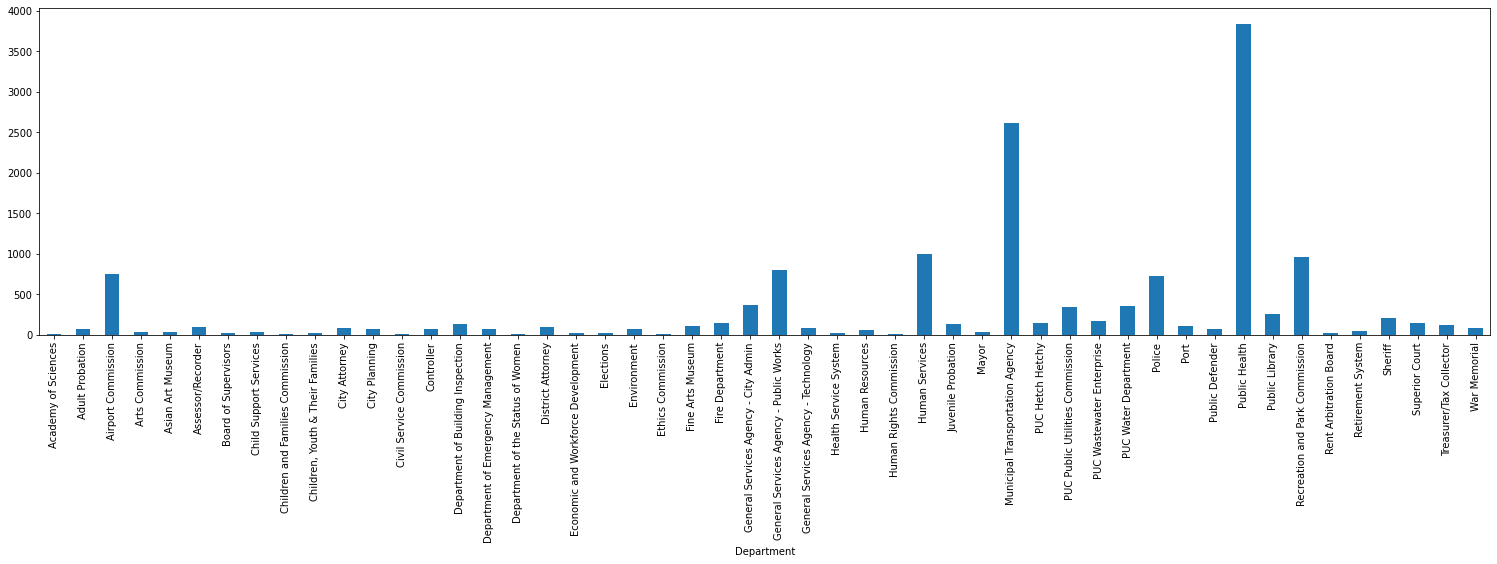

In [44]:
ave_50_sal.groupby('Department')['Job'].count().plot(kind = 'bar', figsize=(26,6))


#Question 5

What percentage of city employees receive benefits through work? If some do not, what are job titles?

---

---





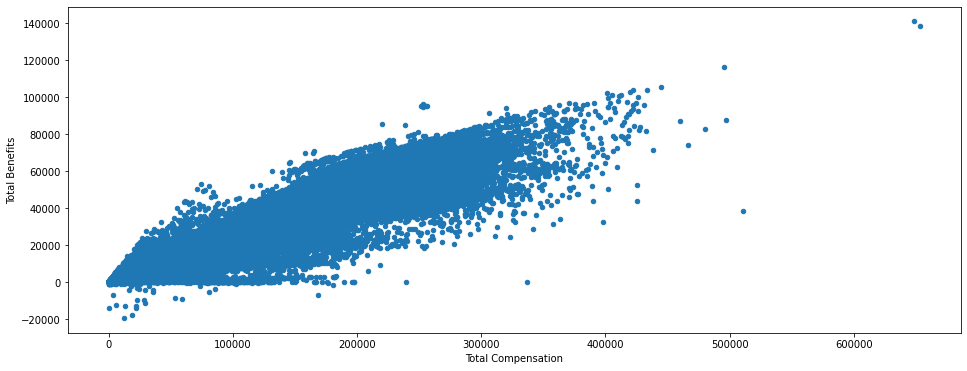

In [45]:
df_comb.plot.scatter(x = 'Total Compensation', y = 'Total Benefits', figsize=(16,6))


In [46]:
mean_sal = []
for bin in list(range(0, 100, 10)):
  tmp = df_comb[(df_comb['Total Compensation'] > df_comb.quantile(bin/100)[-2]) & (df_comb['Total Compensation'] < df_comb.quantile((bin+10)/100)[-2])]['Total Benefits']
  mean_sal.append(tmp.mean())

In [47]:
percentiles = pd.DataFrame(data=[list(range(0, 100, 10)), mean_sal]).transpose()
percentiles.columns = ['Percentile', 'Total Benefits']
percentiles

,Percentile,Total Benefits
0,0.0,914.894861
1,10.0,4160.033682
2,20.0,10518.338199
3,30.0,21098.616145
4,40.0,28591.095627
5,50.0,32224.356402
6,60.0,35492.100010
7,70.0,38904.096477
8,80.0,43002.924596
9,90.0,50532.306344


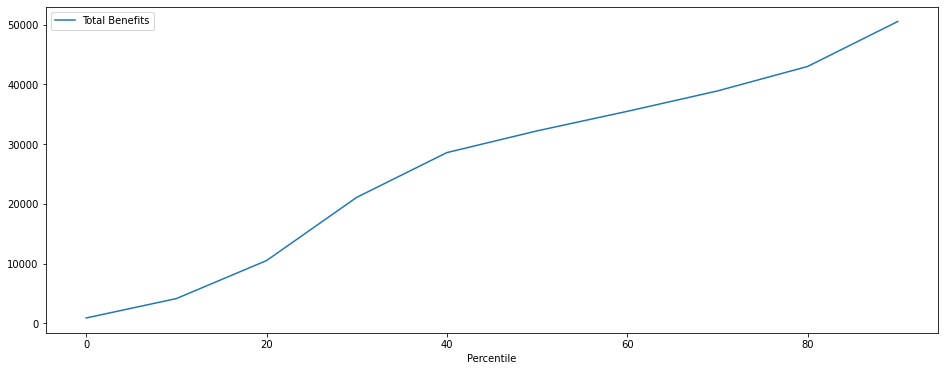

In [48]:
percentiles.plot(x = 'Percentile', y = 'Total Benefits', figsize=(16,6))


There are quite a few employees who are not receiving any benefits through work, and the amount in benefits tend to go up with salary

In [49]:
df_comb[['Job', 'Department', 'Total Benefits', 'Health/Dental']].groupby('Department').mean()

,Total Benefits,Health/Dental
Department,,
Academy of Sciences,28282.766346,9411.326058
Adult Probation,26637.575294,9989.085400
Airport Commission,28189.387995,9749.418236
Arts Commission,28406.851792,9865.684267
Asian Art Museum,21291.562124,8248.566632
Assessor/Recorder,27236.160790,9521.562430
Board of Appeals,15500.895750,5371.740750
Board of Supervisors,23160.355224,7282.006264
Child Support Services,30163.819410,10485.955741


In [50]:
df_comb[df_comb['Total Benefits'] == 0][['Job', 'Department', 'Total Benefits', 'Health/Dental']]

,Job,Department,Total Benefits,Health/Dental
1608,Lieutenant 3,Police,0.0,0.0
2305,Transit Operator,Municipal Transportation Agency,0.0,0.0
4456,Inspector 3,Police,0.0,0.0
4736,Deputy Sheriff,Health Service System,0.0,0.0
6948,Court Administrative Secretary,Health Service System,0.0,0.0
...,...,...,...,...
289988,Deputy Court Clerk III,Health Service System,0.0,0.0
290069,Deputy Sheriff,Health Service System,0.0,0.0
290209,Deputy Court Clerk III,Health Service System,0.0,0.0
290795,Deputy Court Clerk III,Health Service System,0.0,0.0


In [51]:
df_comb[df_comb['Total Benefits'] == 0]['Job'].unique()


array(['Lieutenant 3', 'Transit Operator', 'Inspector 3',
       'Deputy Sheriff', 'Court Administrative Secretary',
       'Deputy Court Clerk II', 'Senior Clerk Typist',
       'Deputy Court Clerk III', 'Pool Lifeguard', 'Manager III',
       'Swimming Instructor', 'Special Nurse', 'Assistant Deputy Chief 2',
       'Police Officer 3', 'Training Technician', 'Sergeant 3',
       'Truck Driver', 'Senior Power House Operator', 'Camp Assistant',
       'Nurse Practitioner', 'Battlion Chief, Fire Suppressi',
       'General Laborer', 'Lieutenant, Fire Suppression',
       'Senior Deputy Sheriff', 'Transit Supervisor', 'Custodian',
       'Deputy Dir II, MTA', 'Institutional Police Officer',
       'Senior Eligibility Worker', 'Customer Service Agent', 'Captain 3',
       'Secretary 2', 'Senior Parking Control Officer',
       'Street Repair Supervisor 2', 'Pr Administrative Analyst',
       "Sheriff's Sergeant", 'Public Safetycomm Disp',
       'Community Development Asst', 'Senior Fisca

In [52]:
df_comb[df_comb['Total Benefits'] == 0]['Department'].unique()


array(['Police', 'Municipal Transportation Agency',
       'Health Service System', 'Recreation and Park Commission',
       'Public Health', 'Fire Department', 'Sheriff', 'Human Services',
       'General Services Agency - City Admin', 'Airport Commission',
       'Juvenile Probation'], dtype=object)

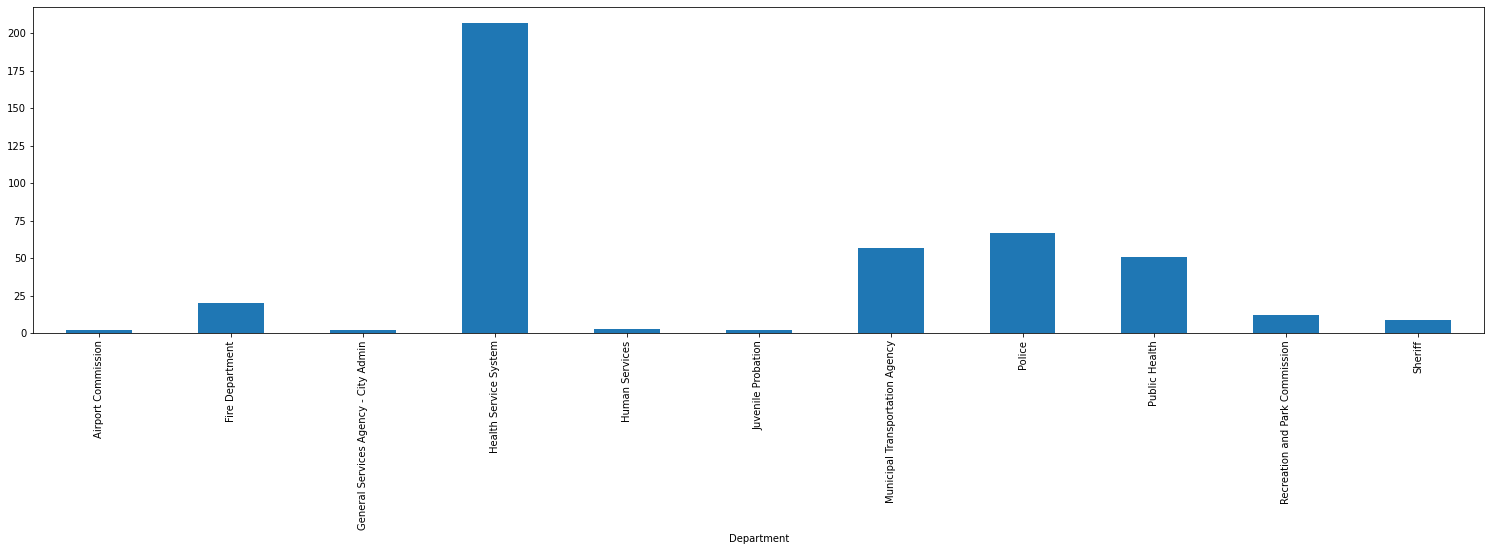

In [53]:
df_comb[df_comb['Total Benefits'] == 0].groupby('Department')['Job'].count().plot(kind = 'bar', figsize=(26,6))


Health Service System is the department that employs the most people who are not receiving benefits through work.

What is the distribution of salaries among the people who are not receiving benefits through work?

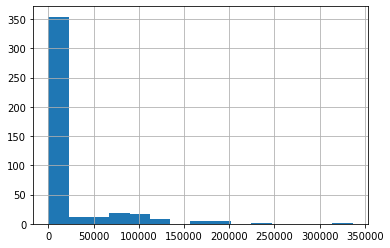

In [54]:
df_comb[df_comb['Total Benefits'] == 0]['Total Compensation'].hist(bins = 15)


It looks like people who are not receiving benefits through work are the same people who caused our confusion in the beginning - people with zero salaries
But what is the percentage of all city employees who are not receiving any benefits?

In [55]:
df_comb[df_comb['Total Benefits'] == 0].shape[0]/df_comb.shape[0]


0.0014825746006143076

#Data Pre-Processing

##Dealing with Missing values

As we could see below, this dataset has very few missing values. Only 43 people are missing union information, which could indicate some people are not part of any union. 45 people are missing Job Family.

In [56]:
df_comb.isnull().sum()

Year Type                   0
Year                        0
Organization Group Code     0
Organization Group          0
Department Code             0
Department                  0
Union Code                 43
Union                      43
Job Family Code            45
Job Family                 45
Job Code                    0
Job                         0
Employee Identifier         0
Salaries                    0
Overtime                    0
Other Salaries              0
Total Salary                0
Retirement                  0
Health/Dental               0
Other Benefits              0
Total Benefits              0
Total Compensation          0
Benefit Portion             0
dtype: int64

Let's take a closer look at the missing values. Looking at table below, we could see that all missing values belong to the same employees. We could just drop it, as 45 rows could hardly affect such a large dataset. But let's look at the Jobs that have Job Family missing anyway

In [57]:
df_comb[df_comb['Job Family'].isnull()].head(45)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation,Benefit Portion
9937,Fiscal,2016,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,NaN,NaN,NaN,NaN,9152,Transportation Controller Trainee,46870,26640.00,1984.87,1982.61,30607.48,5245.44,4489.29,2444.34,12179.07,42786.55,0.284647
17372,Fiscal,2016,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,NaN,NaN,NaN,NaN,9152,Transportation Controller Trainee,36464,32013.30,5983.84,2426.29,40423.43,6324.89,4439.40,3245.97,14010.26,54433.69,0.257382
27989,Fiscal,2016,5,Culture & Recreation,REC,Recreation and Park Commission,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,8100,6888.00,0.00,56.45,6944.45,1527.09,2556.40,550.56,4634.05,11578.50,0.400229
31575,Fiscal,2016,5,Culture & Recreation,REC,Recreation and Park Commission,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,48008,3435.60,0.00,0.00,3435.60,755.49,1275.09,271.93,2302.51,5738.11,0.401266
38030,Fiscal,2016,5,Culture & Recreation,REC,Recreation and Park Commission,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,19116,2688.00,0.00,0.00,2688.00,591.10,997.62,213.96,1802.68,4490.68,0.401427
40110,Fiscal,2016,5,Culture & Recreation,REC,Recreation and Park Commission,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,20672,6333.60,0.00,145.15,6478.75,1424.69,2350.64,513.32,4288.65,10767.40,0.398299
41527,Fiscal,2016,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,NaN,NaN,NaN,NaN,9152,Transportation Controller Trainee,13880,28416.30,0.00,1809.63,30225.93,5522.76,3940.59,2434.63,11897.98,42123.91,0.282452
42154,Fiscal,2016,5,Culture & Recreation,REC,Recreation and Park Commission,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,29346,4834.20,0.00,112.23,4946.43,1087.72,1794.15,394.55,3276.42,8222.85,0.398453
49170,Fiscal,2016,5,Culture & Recreation,REC,Recreation and Park Commission,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,17622,5409.60,0.00,124.99,5534.59,1217.05,2007.70,440.50,3665.25,9199.84,0.398404
49580,Fiscal,2016,5,Culture & Recreation,REC,Recreation and Park Commission,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,44047,672.00,0.00,10.75,682.75,150.14,249.40,52.99,452.53,1135.28,0.398607


In [58]:
mis_job_fam = list(df_comb[df_comb['Job Family'].isnull()]['Job'].unique()) #list of jobs that have Job Family Missing

Maybe any of the employees have job families listed?

In [59]:
for job in mis_job_fam:
  print('There are {} not NaN Job Family values for {} job'.format(df_comb[df_comb['Job'] == job ]['Job Family'].notnull().sum(), job))

There are 0 not NaN Job Family values for Transportation Controller Trainee job
There are 0 not NaN Job Family values for Recreation Facility Assistant job
There are 0 not NaN Job Family values for Managing Director job


Nope. Let's copy job title into job family to Job Family then

In [60]:
mis_job_fam

['Transportation Controller Trainee',
 'Recreation Facility Assistant',
 'Managing Director']

In [61]:
for mis_val in mis_job_fam:
  df_comb.loc[(df_comb['Job Family'].isnull()) & (df_comb['Job'] == mis_val),'Job Family']=mis_val

In [62]:
df_comb[df_comb['Job']== 'Managing Director']['Job Family']

56321    Managing Director
83542    Managing Director
Name: Job Family, dtype: object

Now let's deal with missing Union information. We would assume that these people do not belong to any union, so we would put "None" in the union information

In [63]:
df_comb.loc[(df_comb['Union'].isnull()),'Union']= 'None'

##Selecting columns

We are going to start building a linear model. Let's figure out what columns are in the dataset that we could use to predict Total Compensation and which models we should drop

In [64]:
df_comb.columns

Index(['Year Type', 'Year', 'Organization Group Code', 'Organization Group',
       'Department Code', 'Department', 'Union Code', 'Union',
       'Job Family Code', 'Job Family', 'Job Code', 'Job',
       'Employee Identifier', 'Salaries', 'Overtime', 'Other Salaries',
       'Total Salary', 'Retirement', 'Health/Dental', 'Other Benefits',
       'Total Benefits', 'Total Compensation', 'Benefit Portion'],
      dtype='object')

All the columns that have a code are redundant since these just encode the category it relates to. We could drop them first.
As well as Employee identifyer

In [65]:
df_comb = df_comb.drop(['Organization Group Code', 'Department Code', 'Union Code', 'Job Family Code', 'Job Code', "Employee Identifier"], axis = 1)

In [66]:
df_comb.columns

Index(['Year Type', 'Year', 'Organization Group', 'Department', 'Union',
       'Job Family', 'Job', 'Salaries', 'Overtime', 'Other Salaries',
       'Total Salary', 'Retirement', 'Health/Dental', 'Other Benefits',
       'Total Benefits', 'Total Compensation', 'Benefit Portion'],
      dtype='object')

In [67]:
df_comb['Year'].unique()

array([2016, 2013, 2015, 2014])

##Feature Engineering

We are going to sort Jobs in Departments and job families within these departments by total compensation to get a rank for every job title

In [68]:
#df_comb.groupby(['Department', 'Job Family']).rank(axis = 1, method = 'first')
df_comb["rank"] = df_comb.groupby(['Department', 'Job Family'])["Total Compensation"].rank("first", ascending=False)

In [69]:
df_comb[(df_comb['Department'] == "District Attorney") & (df_comb['Job Family'] == "Legal & Court")].sort_values('rank').head(10)

,Year Type,Year,Organization Group,Department,Union,Job Family,Job,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation,Benefit Portion,rank
252796,Fiscal,2016,Public Protection,District Attorney,Elected Officials,Legal & Court,District Attorney,260907.46,0.0,0.0,260907.46,47302.53,13068.80,19039.08,79410.41,340317.87,0.233342,1.0
135723,Fiscal,2015,Public Protection,District Attorney,Elected Officials,Legal & Court,District Attorney,253078.65,0.0,0.0,253078.65,55525.40,12500.56,19009.66,87035.62,340114.27,0.255901,2.0
237726,Calendar,2015,Public Protection,District Attorney,Elected Officials,Legal & Court,District Attorney,255329.14,0.0,0.0,255329.14,51352.43,12424.50,18644.40,82421.33,337750.47,0.244030,3.0
33727,Calendar,2014,Public Protection,District Attorney,Elected Officials,Legal & Court,District Attorney,248767.06,0.0,0.0,248767.06,53139.92,13054.94,19626.17,85821.03,334588.09,0.256498,4.0
20535,Calendar,2013,Public Protection,District Attorney,Elected Officials,Legal & Court,District Attorney,252221.06,0.0,0.0,252221.06,48342.29,12918.24,19291.19,80551.72,332772.78,0.242062,5.0
98426,Fiscal,2014,Public Protection,District Attorney,Elected Officials,Legal & Court,District Attorney,246665.08,0.0,0.0,246665.08,51355.67,12512.55,19180.48,83048.70,329713.78,0.251881,6.0
47309,Fiscal,2013,Public Protection,District Attorney,Elected Officials,Legal & Court,District Attorney,240430.71,0.0,0.0,240430.71,42580.21,12801.79,19112.90,74494.90,314925.61,0.236548,7.0
217077,Fiscal,2016,Public Protection,District Attorney,Municipal Attorneys' Association,Legal & Court,Assistant Chief Attorney 2,223835.25,0.0,5976.7,229811.95,41773.72,13068.80,12062.49,66905.01,296716.96,0.225484,8.0
180645,Calendar,2015,Public Protection,District Attorney,Municipal Attorneys' Association,Legal & Court,Assistant Chief Attorney 2,218440.02,0.0,3697.8,222137.82,44789.90,12424.50,11551.94,68766.34,290904.16,0.236388,9.0
39263,Fiscal,2015,Public Protection,District Attorney,Municipal Attorneys' Association,Legal & Court,Assistant Chief Attorney 2,216129.42,0.0,1554.4,217683.82,47840.13,12500.56,11575.71,71916.40,289600.22,0.248330,10.0


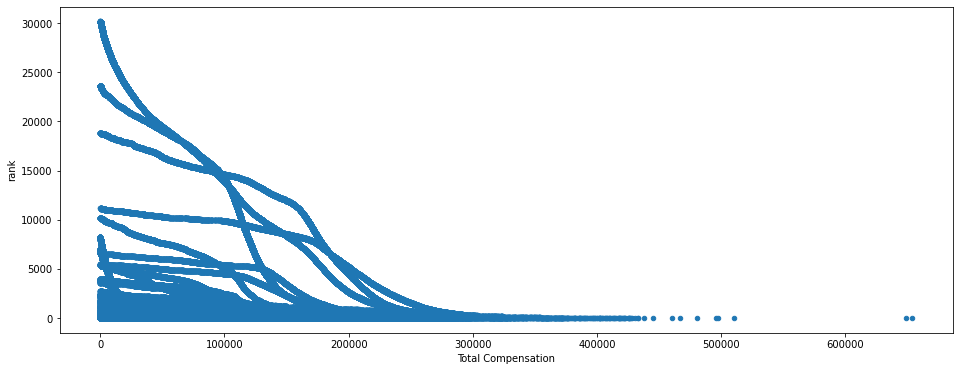

In [70]:
df_comb.plot.scatter(x = 'Total Compensation', y = 'rank', figsize=(16,6))


As we are predicting Total Compensation and there are a few columns that deal with the salary information, we need to be very careful with the columns we include. We could accidentally give the model the right answer. For now we are going to drop [ 'Salaries', 'Total Salary', 'Benefit Portion']

In [71]:
df_comb = df_comb.drop(['Salaries', 'Total Salary', 'Benefit Portion'], axis = 1)

In [72]:
df_comb.columns

Index(['Year Type', 'Year', 'Organization Group', 'Department', 'Union',
       'Job Family', 'Job', 'Overtime', 'Other Salaries', 'Retirement',
       'Health/Dental', 'Other Benefits', 'Total Benefits',
       'Total Compensation', 'rank'],
      dtype='object')

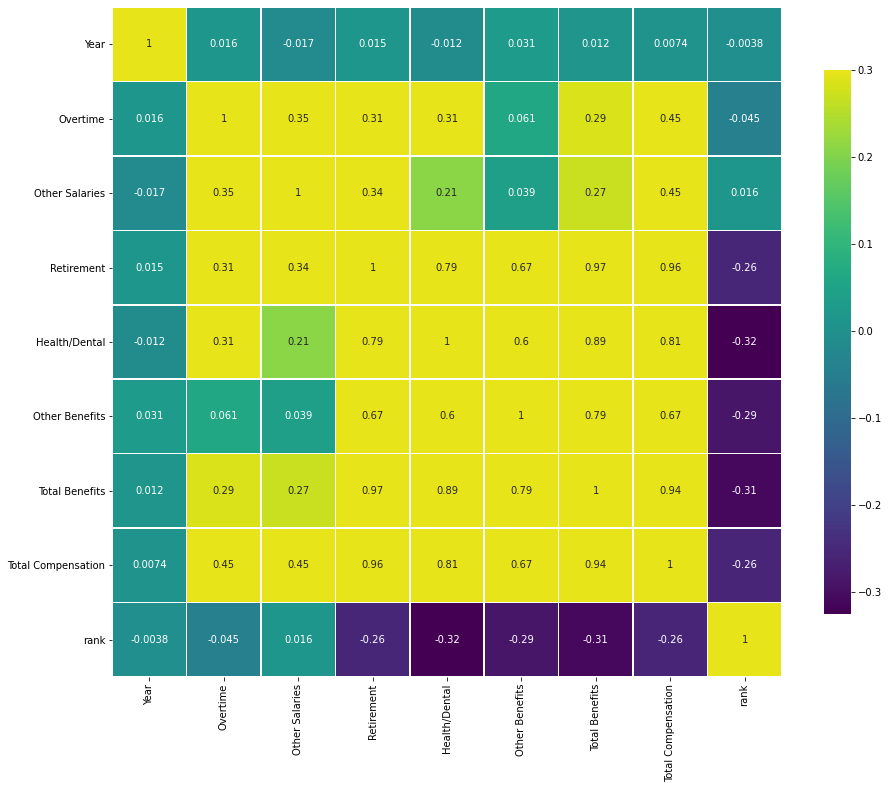

In [73]:
# Compute the correlation matrix
dfa_corr = df_comb.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dfa_corr, cmap='viridis', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In [74]:
dfa_corr['Total Compensation'].sort_values(ascending = False)

Total Compensation    1.000000
Retirement            0.956899
Total Benefits        0.943324
Health/Dental         0.805312
Other Benefits        0.669026
Overtime              0.452924
Other Salaries        0.450572
Year                  0.007383
rank                 -0.257578
Name: Total Compensation, dtype: float64

In [75]:
df_counts = df_comb.groupby(['Department','Job Family'])['Year'].count().reset_index()

In [76]:
tmp1=df_counts[df_counts.Year>500]
tmp1

,Department,Job Family,Year
13,Adult Probation,Probation & Parole,760
19,Airport Commission,Airport Operation,1113
22,Airport Commission,"Clerical, Secretarial & Steno",817
30,Airport Commission,Housekeeping & Laundry,3545
31,Airport Commission,Information Systems,547
...,...,...,...
748,Recreation and Park Commission,Recreation,8217
776,Sheriff,Correction & Detention,6632
789,Superior Court,SF Superior Court,3987
796,Treasurer/Tax Collector,"Payroll, Billing & Accounting",511


In [77]:
tmp2=pd.merge(df_comb, tmp1, how="left", on=["Department", "Job Family"])
df_comb=tmp2[tmp2['Year_y'].notnull()]
df_comb.drop('Year_y', axis = 1)
df_comb.groupby(['Department','Job Family']).count()


Year Type  ...  Year_y
Department                     Job Family                                ...        
Adult Probation                Probation & Parole                   760  ...     760
Airport Commission             Airport Operation                   1113  ...    1113
                               Clerical, Secretarial & Steno        817  ...     817
                               Housekeeping & Laundry              3545  ...    3545
                               Information Systems                  547  ...     547
...                                                                 ...  ...     ...
Recreation and Park Commission Recreation                          8217  ...    8217
Sheriff                        Correction & Detention              6632  ...    6632
Superior Court                 SF Superior Court                   3987  ...    3987
Treasurer/Tax Collector        Payroll, Billing & Accounting        511  ...     511
                               Revenue                              557  ...     557

[97 rows x 14 columns]

In [78]:
df_comb.head(10)

,Year Type,Year_x,Organization Group,Department,Union,Job Family,Job,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation,rank,Year_y
0,Fiscal,2016,Public Protection,District Attorney,Municipal Attorneys' Association,Legal & Court,Attorney (Civil/Criminal),0.00,1500.00,21025.98,13068.80,9368.71,43463.49,159436.65,732.0,1991.0
2,Calendar,2015,Community Health,Public Health,"SEIU - Human Services, Local 1021",Human Services,Eligibility Worker,0.00,798.43,0.00,2254.93,835.11,3090.04,13868.64,3735.0,4013.0
3,Fiscal,2015,Community Health,Public Health,"SEIU - Health Workers, Local 1021",Medical & Dental,Dental Aide,0.00,0.00,0.00,622.63,222.46,845.09,3718.50,2159.0,2253.0
4,Fiscal,2014,Culture & Recreation,Recreation and Park Commission,"SEIU - Miscellaneous, Local 1021",Recreation,Recreation Leader,0.00,176.70,0.00,2711.66,538.43,3250.09,10128.64,3345.0,8217.0
5,Fiscal,2013,"Public Works, Transportation & Commerce",General Services Agency - Public Works,"Prof & Tech Engineers - Miscellaneous, Local 21",Sub-Professional Engineering,"Stdntdsgntrain1, Arch/Eng/Plng",0.00,0.00,9386.03,11780.60,3486.34,24652.97,69974.15,310.0,1283.0
6,Fiscal,2015,Culture & Recreation,Public Library,"SEIU - Miscellaneous, Local 1021",Library,Library Assistant,0.00,1193.14,6616.52,5793.48,2430.74,14840.74,44339.38,3321.0,5344.0
7,Fiscal,2014,General Administration & Finance,Assessor/Recorder,"Prof & Tech Engineers - Miscellaneous, Local 21",Appraisal & Taxation,Real Property Appraiser,0.00,800.00,8685.34,7269.02,3277.52,19231.88,59969.97,732.0,1000.0
8,Calendar,2015,Public Protection,Police,Police Officers' Association,Police Services,Lieutenant (Police Department),2312.73,20944.16,4183.12,1911.46,68.84,6163.42,52532.31,16248.0,18805.0
9,Fiscal,2014,Public Protection,Sheriff,Deputy Sheriffs' Association,Correction & Detention,Deputy Sheriff,6856.77,5563.78,17596.33,12512.55,1627.91,31736.79,133258.56,4866.0,6632.0
10,Fiscal,2015,"Public Works, Transportation & Commerce",Airport Commission,"SEIU - Miscellaneous, Local 1021",Public Service Aide,Publ Svc Aide-Asst To Prof,0.00,0.00,0.00,2361.82,549.01,2910.83,10002.16,226.0,671.0


In [79]:
df_comb.isna().sum()

Year Type             0
Year_x                0
Organization Group    0
Department            0
Union                 0
Job Family            0
Job                   0
Overtime              0
Other Salaries        0
Retirement            0
Health/Dental         0
Other Benefits        0
Total Benefits        0
Total Compensation    0
rank                  0
Year_y                0
dtype: int64

##Creating Dummy Variables

In [80]:
#get categorical columns
cat_df_col = df_comb.select_dtypes(include = object).columns

In [81]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    df_temp = pd.get_dummies(df[cat_cols], dummy_na = dummy_na, drop_first=True)
    df_temp = pd.concat([df, df_temp], axis=1)
    df_temp = df_temp.drop(columns=cat_cols)
    return df_temp

Let's do our last attempt to make our prediction better before I give up completely. We are going to create a linear model for every Job Family within each department and get a mean score for every model. As we saw ranks within each deparmtent and total compensation do fall along lines give me some hope for a better result 

In [82]:
test_score_list = []
train_score_list = []
depart = []
job_fami = []

In [83]:
dep_list = list(df_comb['Department'].unique()) 

It looks like we should drop 'Managing Director" after all. There are nearly not enough people to predict anything

#Create, Fit, and Predict

In [84]:
for dep in dep_list:
  job_list = list(df_comb[df_comb['Department']== dep]["Job Family"].unique())
  for job_fam in job_list:
    #Split into explanatory and response variables
    df_new = df_comb[(df_comb['Department']== dep) & (df_comb['Job Family']== job_fam)]
    df_new = create_dummy_df(df_new, cat_df_col, dummy_na = False)
    X = df_new.drop(['Total Compensation'], axis = 1)
    y = df_new['Total Compensation']
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42) 

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit
    
    #Predict and score the model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)
    test_score_temp = r2_score(y_test, y_test_preds)
    train_score_temp = r2_score(y_train, y_train_preds)
    test_score_list.append(test_score_temp)
    train_score_list.append(train_score_temp)
    depart.append(dep)
    job_fami.append(job_fam)


In [85]:


test_score = statistics.mean(test_score_list)
train_score = statistics.mean(train_score_list)

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))


The rsquared on the training data was -0.8873044245903906.  The rsquared on the test data was -1.8821322765270424e+16.


Well, that does not look good for an overall score. Let's look at scores by Job Family within each department

In [86]:
result = pd.DataFrame(data=[depart,job_fami, test_score_list, train_score_list]).transpose()
result.columns = ['Department', 'Job Family', "train_score", "test_score"]

In [87]:
result

,Department,Job Family,train_score,test_score
0,District Attorney,Legal & Court,0.991153,0.993201
1,Public Health,Human Services,0.998059,0.997403
2,Public Health,Medical & Dental,0.883965,0.884841
3,Public Health,Nursing,0.984689,0.984735
4,Public Health,Dietary & Food,0.996467,0.997694
...,...,...,...,...
92,Human Resources,Personnel,0.998052,0.997564
93,Adult Probation,Probation & Parole,0.884886,0.9208
94,Controller,"Payroll, Billing & Accounting",0.953489,0.954136
95,Public Defender,Legal & Court,0.994384,0.995213


Currently, not all of our models perform fine. It is possible that some departments have bad data and/or significant outliers that throw the model way off. For the sake of time constrain of this project, we would recommend this model only for select departments